In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

In [29]:
spark = SparkSession.builder.appName("AirlinePassengerSatisfaction").getOrCreate()
sc = spark.sparkContext 

train =  spark.read.csv('train.csv', header=True, inferSchema=True)  
test =  spark.read.csv('test.csv', header=True, inferSchema=True)  

print("Train data: Number of rows:", train.count(), ", Number of columns:", len(train.columns))
print("Test data: Number of rows:", test.count(), ", Number of columns:", len(test.columns))

Train data: Number of rows: 103904 , Number of columns: 25
Test data: Number of rows: 25976 , Number of columns: 25


In [30]:
# Examine the dataset
print("Column names:", train.columns)
print("Data types:\n", train.dtypes)

Column names: ['_c0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']
Data types:
 [('_c0', 'int'), ('id', 'int'), ('Gender', 'string'), ('Customer Type', 'string'), ('Age', 'int'), ('Type of Travel', 'string'), ('Class', 'string'), ('Flight Distance', 'int'), ('Inflight wifi service', 'int'), ('Departure/Arrival time convenient', 'int'), ('Ease of Online booking', 'int'), ('Gate location', 'int'), ('Food and drink', 'int'), ('Online boarding', 'int'), ('Seat comfort', 'int'), ('Inflight entertainment', 'int'), ('On-board service', 'int'), ('Leg room service', 'int'), ('Baggage handl

In [36]:
columns_to_drop = ['_c0', 'id']

train = train.drop(*columns_to_drop)
test = test.drop(*columns_to_drop)

In [37]:
# Summary statistics
print("Summary statistics:\n", train.describe())

Summary statistics:
 DataFrame[summary: string, Gender: string, Customer Type: string, Age: string, Type of Travel: string, Class: string, Flight Distance: string, Inflight wifi service: string, Departure/Arrival time convenient: string, Ease of Online booking: string, Gate location: string, Food and drink: string, Online boarding: string, Seat comfort: string, Inflight entertainment: string, On-board service: string, Leg room service: string, Baggage handling: string, Checkin service: string, Inflight service: string, Cleanliness: string, Departure Delay in Minutes: string, Arrival Delay in Minutes: string, satisfaction: string]


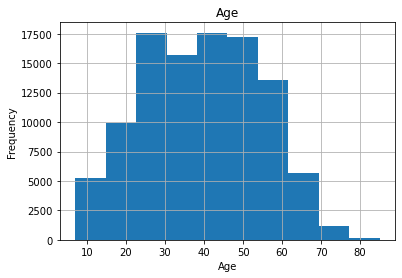

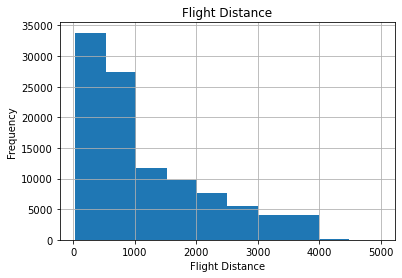

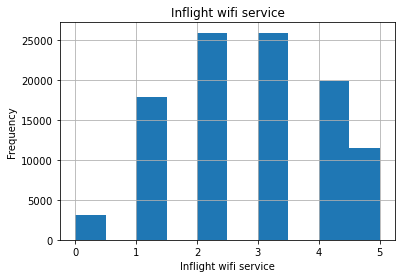

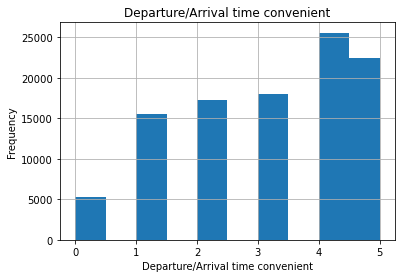

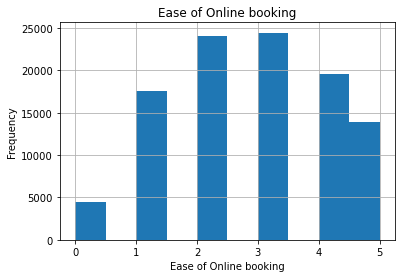

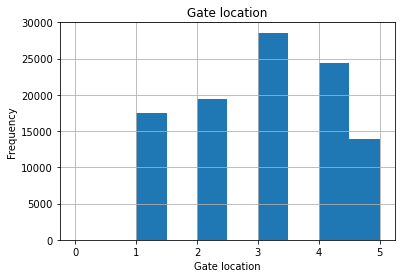

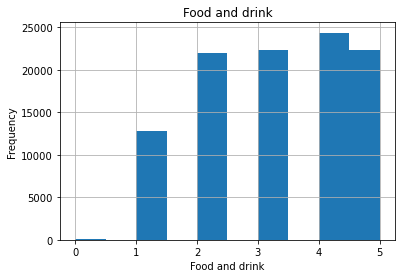

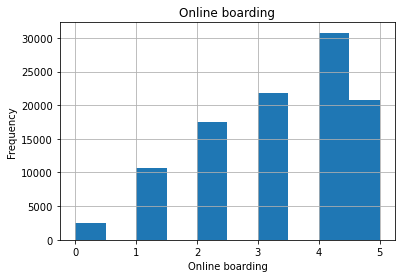

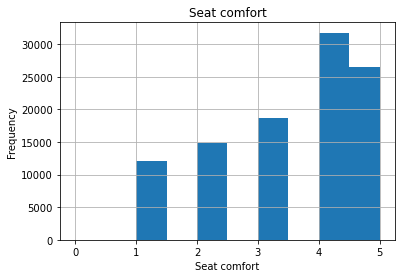

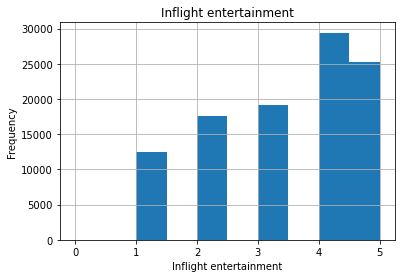

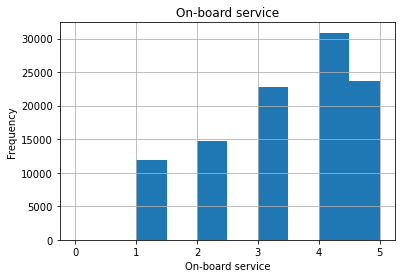

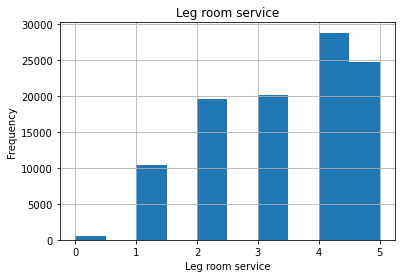

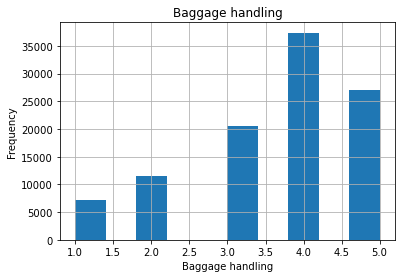

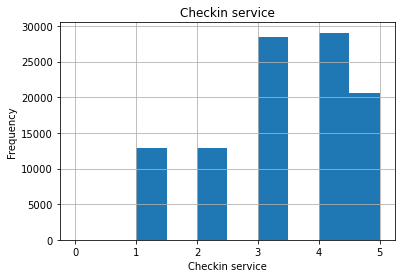

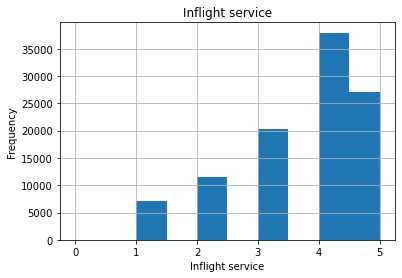

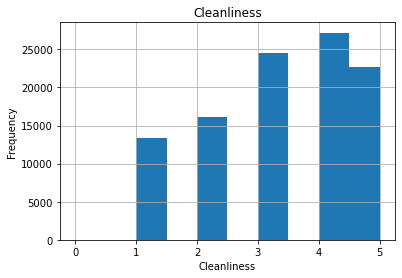

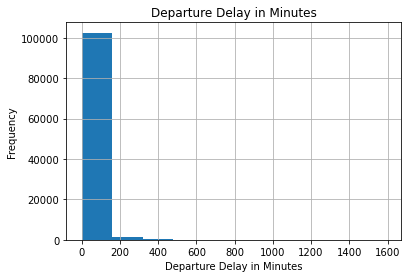

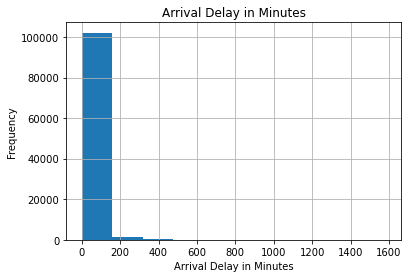

In [55]:
# Visualize the data - Histograms

# train_pandas = train.toPandas()

# train.hist(figsize=(10, 6))
# plt.tight_layout()
# plt.show()


# def plot_histograms(df):

#     # Get numerical columns
#     numerical_cols = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'bigint', 'float', 'double']]
    
#     # Plot histograms for each numerical column
#     for col in numerical_cols:

#         # Generate histogram data
#         hist_data = df.select(col).rdd.flatMap(lambda x: x).histogram(10)
#         bins, counts = hist_data

#         # Plot histogram
#         plt.figure(figsize=(6, 4))
#         plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
#         plt.xlabel('Bins')
#         plt.ylabel('Frequency')
#         plt.title(f'Histogram of {col}')
#         plt.show()

# plot_histograms(train)

def plot_histograms(df):

    df_pd = df.toPandas()

    # Get numerical columns
    numerical_columns = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'bigint', 'float', 'double']]
    
    # Plot histograms for each numerical column
    for column in numerical_columns:

        # Generate histogram data
        df_pd[column].hist()
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

plot_histograms(train)



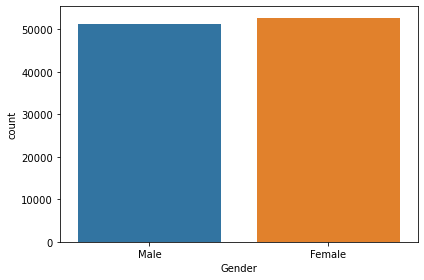

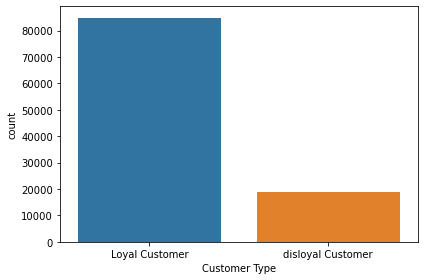

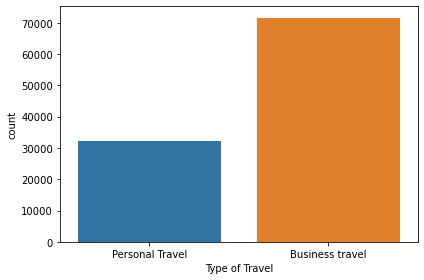

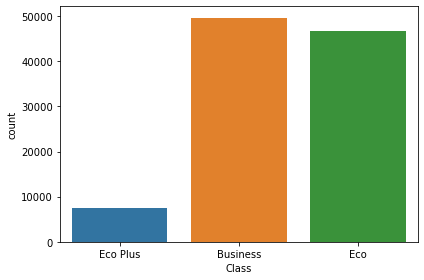

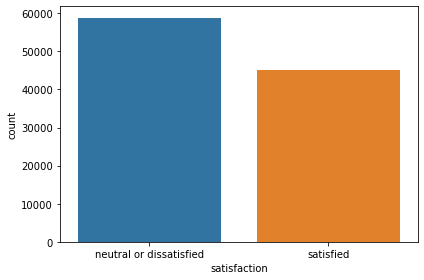

In [56]:

def plot_countplots(df):

    df_pd = df.toPandas()

    # Select categorical columns (non-numeric)
    categorical_columns = df_pd.select_dtypes(include=['object']).columns

    # Visualize the data - Count plots for categorical columns
    for column in categorical_columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df_pd, x=column)
        plt.tight_layout()
        plt.show()

plot_countplots(train)



In [47]:
# Handle missing data
print("Missing values count:\n", train.toPandas().isnull().sum())


Missing values count:
 Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64


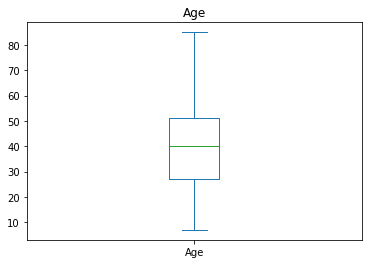

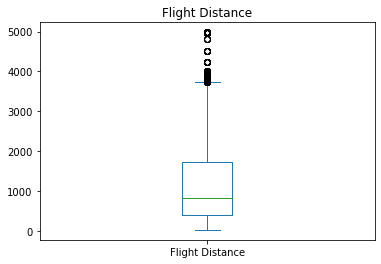

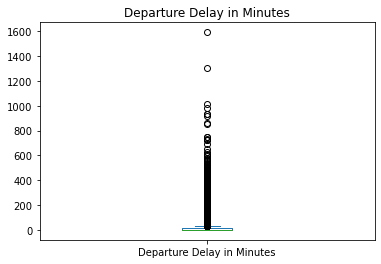

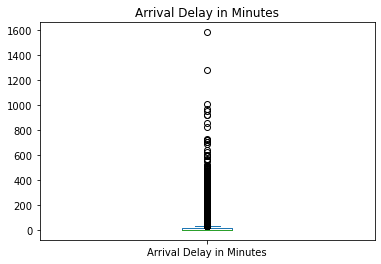

In [57]:
# Filter numeric columns
df_pd = train.toPandas()
numerical_columns = df_pd[['Age', 'Flight Distance', 'Departure Delay in Minutes','Arrival Delay in Minutes']]

for column in numerical_columns:
    plt.figure(figsize=(6, 4))
    df_pd[column].plot(kind='box')
    plt.title(column)
    plt.show()

In [59]:
# Baseline Model - ZeroR
df_pd = train.toPandas()
baseline_class = df_pd['satisfaction'].value_counts().idxmax()
print("Baseline class:", baseline_class)

Baseline class: neutral or dissatisfied


In [61]:
# Random samples
df_pd = train.toPandas()
random_samples = df_pd.sample(n=5)  # Change the value of 'n' to the desired number of random samples
print("Random samples:\n", random_samples)

Random samples:
        Gender      Customer Type  Age   Type of Travel     Class  \
58466  Female     Loyal Customer   57  Business travel  Business   
97834    Male  disloyal Customer   15  Business travel       Eco   
70520    Male  disloyal Customer   25  Business travel       Eco   
91601    Male  disloyal Customer   27  Business travel       Eco   
60168  Female     Loyal Customer   45  Business travel       Eco   

       Flight Distance  Inflight wifi service  \
58466             2288                      2   
97834             1330                      3   
70520              948                      4   
91601              337                      3   
60168              296                      3   

       Departure/Arrival time convenient  Ease of Online booking  \
58466                                  2                       2   
97834                                  3                       3   
70520                                  5                       5   
91601  